In [2]:
import os
from pathlib import Path

In [1]:
import tensorflow as tf
import cv2 as cv
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

2025-06-26 22:20:34.567087: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-26 22:20:34.573516: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-26 22:20:34.591988: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750969234.631541  698176 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750969234.641324  698176 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750969234.666956  698176 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [3]:
data_dir = Path(os.getcwd()) / ".dataset"
train_directory = data_dir / "Training"
test_directory = data_dir / "Testing"

In [9]:
_seed = 9118487
validation_split = .2

mlp_train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_directory,
    labels="inferred",
    label_mode="int",
    batch_size=32,
    validation_split=validation_split,
    subset='training',
    seed=_seed
)

mlp_validation_dataset = tf.keras.utils.image_dataset_from_directory(
    train_directory,
    labels="inferred",
    label_mode="int",
    batch_size=32,
    validation_split=validation_split,
    subset='validation',
    seed=_seed
)

mlp_test_dateset = tf.keras.utils.image_dataset_from_directory(
    test_directory,
    labels="inferred",
    label_mode="int",
    batch_size=32,
    seed=_seed
)

Found 2870 files belonging to 4 classes.
Using 2296 files for training.
Found 2870 files belonging to 4 classes.
Using 574 files for validation.
Found 394 files belonging to 4 classes.


In [10]:
for images, labels in mlp_train_dataset.take(1):
    img = images[0].numpy().astype("uint8")
    # label = labels[0].numpy()
    label = labels[0]
    input_data_shape = np.array(img).shape

2025-06-26 22:27:40.176646: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [19]:
best_hps_values = {
    'num_layers': 2,
    'units_0': 128,
    'units_1': 64,
    'activation': 'relu',
    'use_dropout': True,
    'dropout': 0.3,
    'learning_rate': 0.001
}

def create_best_mlp_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=input_data_shape))
    
    for i in range(best_hps_values.get('num_layers')):
        model.add(tf.keras.layers.Dense(
            units=best_hps_values.get(f'units_{i}'),
            activation=best_hps_values.get('activation')
        ))
        if best_hps_values.get('use_dropout'):
            model.add(tf.keras.layers.Dropout(rate=best_hps_values.get('dropout')))
    
    model.add(tf.keras.layers.Dense(4, activation='softmax'))
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=best_hps_values.get('learning_rate')),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [39]:
mlp_model = create_best_mlp_model()

/home/mateusz/dev/pjatk_wum_project/.env/neural_net/lib64/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [40]:
mlp_model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_6 (Flatten)             │ (None, 196608)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 128)            │    25,165,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,174,468 (96.03 MB)

 Trainable params: 25,174,468 (96.03 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

mlp_history = mlp_model.fit(
    mlp_train_dataset,
    validation_data=mlp_validation_dataset,
    epochs=50,
    callbacks=[early_stop]
)

Epoch 1/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 26s 342ms/step - accuracy: 0.2870 - loss: 2968.6489 - val_accuracy: 0.3240 - val_loss: 1.3720
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 23s 319ms/step - accuracy: 0.2664 - loss: 1.3718 - val_accuracy: 0.3240 - val_loss: 1.3589
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 24s 340ms/step - accuracy: 0.2844 - loss: 1.4496 - val_accuracy: 0.3240 - val_loss: 1.3518
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 27s 379ms/step - accuracy: 0.2690 - loss: 1.3549 - val_accuracy: 0.2648 - val_loss: 1.3489
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 28s 388ms/step - accuracy: 0.2753 - loss: 1.3514 - val_accuracy: 0.2648 - val_loss: 1.3477
Epoch 6/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 26s 363ms/step - accuracy: 0.2936 - loss: 1.3546 - val_accuracy: 0.2648 - val_loss: 1.3472
Epoch 7/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 28s 382ms/step - accuracy: 0.2683 - loss: 1.3591 - val_accuracy: 0.2648 - val_loss: 1.3469
Epoch 8/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 26s 359ms/step - accuracy: 0.3149 - loss: 1.3513 - val_a

KeyboardInterrupt: 

In [33]:
best_mlp_model_json_path = Path(os.getcwd()) / "best_mlp_model" / "config.json"

if best_mlp_model_json_path.exists():
    with open(best_mlp_model_json_path, 'r') as json_file:
        model_json = json_file.read()
    best_mlp_model = tf.keras.models.model_from_json(model_json)
    best_mlp_model.load_weights(Path(os.getcwd()) / "best_mlp_model" / "weights.h5")

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/home/mateusz/dev/pjatk_wum_project/best_mlp_model/weights.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [32]:
best_mlp_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=best_hps_values.get('learning_rate')),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

In [34]:
mlp_model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_5 (Flatten)             │ (None, 196608)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │    25,165,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,523,406 (288.10 MB)

 Trainable params: 25,174,468 (96.03 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 50,348,938 (192.07 MB)

In [38]:
mlp_loss, mlp_accuracy = mlp_model.evaluate(mlp_test_dateset)
print(f"MLP Test Accuracy: {mlp_accuracy:.2f}, MLP Test")

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.2616 - loss: 1.3939
MLP Test Accuracy: 0.25, MLP Test


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Classificati

/home/mateusz/dev/pjatk_wum_project/.env/neural_net/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/mateusz/dev/pjatk_wum_project/.env/neural_net/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/mateusz/dev/pjatk_wum_project/.env/neural_net/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control 

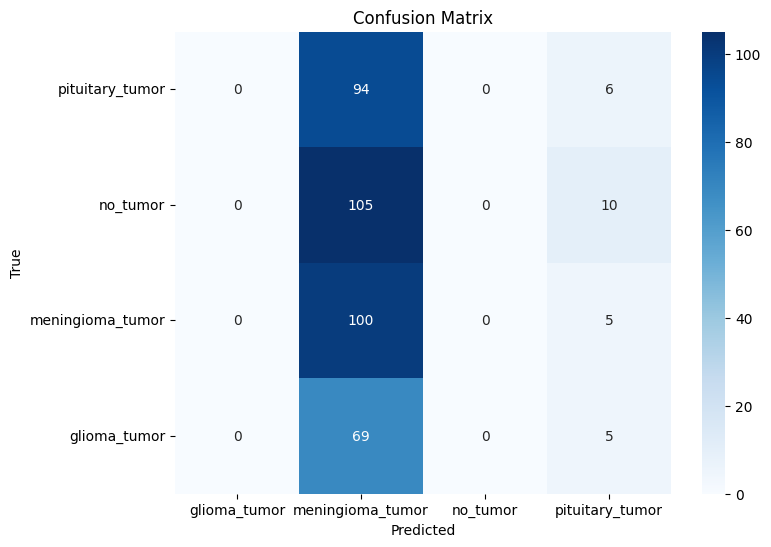

In [48]:
# Evaluate model on test dataset and show confusion matrix and classification report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Extract class names from the dataset
class_names = mlp_test_dateset.class_names

# Get true labels and predictions
true_labels = []
pred_labels = []
for images, labels in mlp_test_dateset:
    preds = mlp_model.predict(images)
    pred_labels.extend(np.argmax(preds, axis=1))
    true_labels.extend(labels.numpy())

# Compute confusion matrix and classification report
cm = confusion_matrix(true_labels, pred_labels)
report = classification_report(true_labels, pred_labels, target_names=class_names)

print("Classification Report:\n", report)

# Plot confusion matrix with class names, flipping y-axis
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names[::-1])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


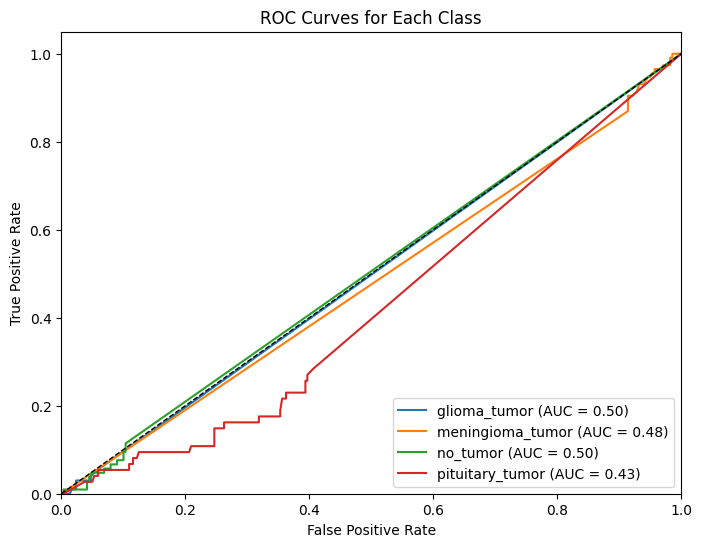

In [49]:
# Plot ROC curves and calculate AUC for each class
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the true labels for ROC computation
n_classes = len(class_names)
y_true_bin = label_binarize(true_labels, classes=range(n_classes))
y_score = []
for images, _ in mlp_test_dateset:
    preds = mlp_model.predict(images)
    y_score.append(preds)
y_score = np.concatenate(y_score, axis=0)

plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Class')
plt.legend(loc='lower right')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


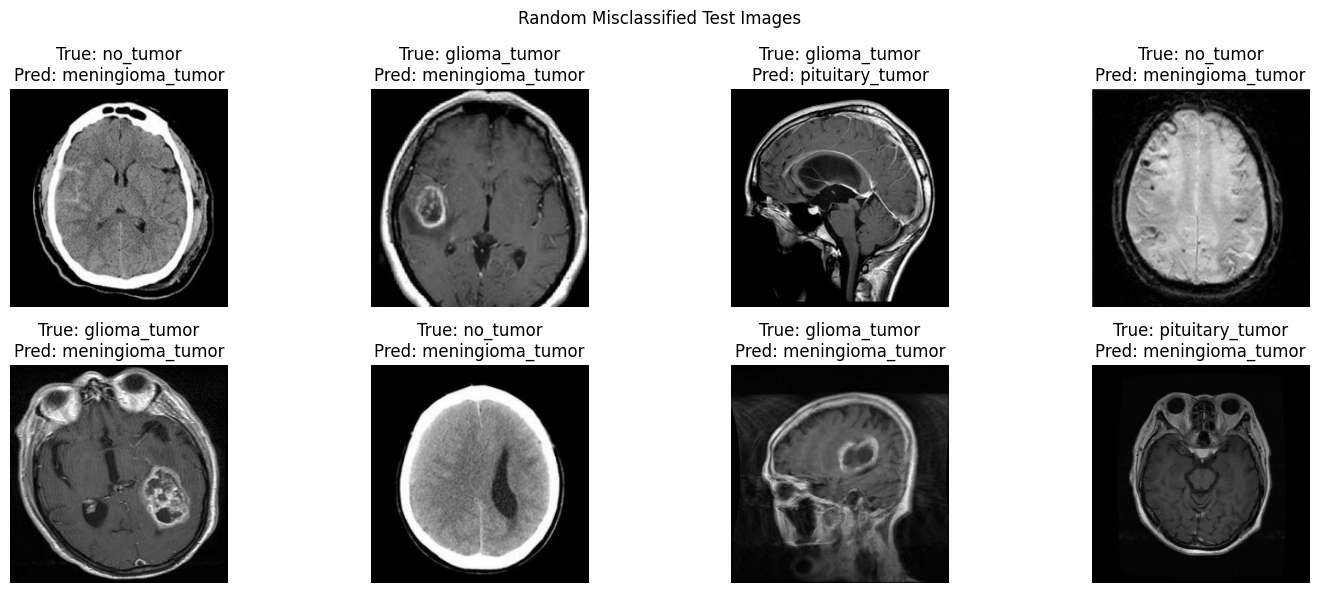

In [50]:
# Display a few misclassified images with their true and predicted labels
import random

# Collect all test images and their labels
all_images = []
all_true = []
all_pred = []
for images, labels in mlp_test_dateset:
    preds = mlp_model.predict(images)
    pred_classes = np.argmax(preds, axis=1)
    for i in range(len(images)):
        all_images.append(images[i].numpy().astype('uint8'))
        all_true.append(labels[i].numpy())
        all_pred.append(pred_classes[i])

misclassified_idxs = [i for i, (t, p) in enumerate(zip(all_true, all_pred)) if t != p]

# Show up to 8 random misclassified images
num_to_show = min(8, len(misclassified_idxs))
if num_to_show > 0:
    plt.figure(figsize=(15, 6))
    for i, idx in enumerate(random.sample(misclassified_idxs, num_to_show)):
        plt.subplot(2, 4, i+1)
        plt.imshow(all_images[idx])
        plt.title(f"True: {class_names[all_true[idx]]}\nPred: {class_names[all_pred[idx]]}")
        plt.axis('off')
    plt.suptitle('Random Misclassified Test Images')
    plt.tight_layout()
    plt.show()
else:
    print("No misclassified images found.")